In [1]:
import csv
import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:

# Read csv file
# sample
lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    first_line = True
    for line in reader:
        if first_line:
            first_line = False
            continue 
        lines.append(line)
        
# collected

#lines_col = []
#with open('data/ud/driving_log.csv') as csvfile:
#    reader = csv.reader(csvfile)
#    for line in reader:
#        lines_col.append(line) 


In [3]:
# Rotation
def rotate(image, angle):
    rows,cols,depth = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated = cv2.warpAffine(image, M, (cols,rows), 
                            flags = cv2.INTER_NEAREST,
                            borderMode = cv2.BORDER_REPLICATE)
    return rotated

def shear(image):
    rows,cols,depth = image.shape
    M = np.float32([[1,0.2,0],[0.2,1,0]])
    sheared = cv2.warpAffine(image, M, (cols,rows), 
                            flags = cv2.INTER_LINEAR,
                            borderMode = cv2.BORDER_REPLICATE)
    return sheared

In [4]:
# Load images
def generate(samples, batch_size = 32):
    images_ = []
    measures_ = []
    num_samples = len(samples)

    while 1:
        batch_counter = 0
        for batch in range(0, num_samples, batch_size):
            batch_samples = samples[batch: batch + batch_size]

            images_ = []
            measures_ = []
            for line in batch_samples:
                correction = [0.0, 0.2, -0.2];
                for i in range(3):
                    image_path = line[i]
                    filename = image_path.split('/')[-1]
                    if filename.endswith('.jpg'):
                        current_path = 'data/IMG/' + filename
                        image = cv2.imread(current_path)
                        images_.append(image)
                        raw_measure = float(line[3])
                        measure = raw_measure + correction[i]
                        measures_.append(measure)
                        images_.append(cv2.flip(image,1))
                        measures_.append(measure*-1.0)
                        if(abs(raw_measure) > 0.15):
                            images_.append(rotate(image,0.5))
                            images_.append(rotate(image,-0.5))
                            measures_.append(measure)
                            measures_.append(measure)
                        if(abs(raw_measure) > 0.3):
                            images_.append(rotate(image,1.5))
                            images_.append(rotate(image,-1.5))
                            measures_.append(measure)
                            measures_.append(measure)
                        
                    
            X_train = np.array(images_)
            y_train = np.array(measures_)
            yield sklearn.utils.shuffle(X_train, y_train) 

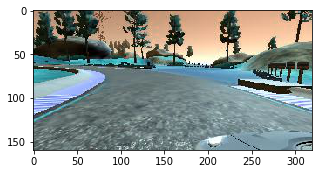

In [5]:
# Display sample image

import matplotlib.pyplot as plt
%matplotlib inline

see_test = []
measure_test = []
for i in range(4):
    see_test, measure_test = (next(generate(lines)))

plt.figure(figsize=(5,5))
plt.imshow(np.array(see_test[10]), cmap = "gray")


In [6]:
# Build model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D

model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70,25), (0,0))))

model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

model.compile(loss='mse',optimizer='adam')
train_samples, validation_samples = train_test_split(lines, test_size = 0.05)
batch_size = 32
num_batches_train = batch_size*(len(train_samples)/batch_size)
num_batches_validation = batch_size*(len(validation_samples)/batch_size)

model.fit_generator(
    generate(train_samples),
    samples_per_epoch = 19200,
    nb_epoch=5, 
    verbose=1,
    validation_data = generate(validation_samples),
    nb_val_samples = 256
    )

model.save('model_07_19_8_56.h5')
print("Model Saved")

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 65, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 31, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

/udacity-SelfDriving/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


19452/19200 [==============================] - 315s - loss: 0.0367 - val_loss: 0.0280
Epoch 2/5
19392/19200 [==============================] - 308s - loss: 0.0249 - val_loss: 0.0140
Epoch 3/5
19242/19200 [==============================] - 311s - loss: 0.0240 - val_loss: 0.0142
Epoch 4/5
19266/19200 [==============================] - 307s - loss: 0.0215 - val_loss: 0.0275
Epoch 5/5
19362/19200 [==============================] - 317s - loss: 0.0215 - val_loss: 0.0180
Model Saved
